In [117]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

In [118]:
import astropy.units as u
import astropy.cosmology.units as cu
import astropy.constants as const

In [119]:
import raytrace

In [120]:
rng = np.random.default_rng()

In [121]:
halo_id = '12925051'

In [123]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    halo = f['halo_' + halo_id]
    print(halo.keys())
    com = halo['GroupCM'][:]
    r500 = halo['Group_R_Crit500'][()]

<KeysViewHDF5 ['GroupCM', 'GroupMassType', 'GroupSFR', 'Group_R_Crit500', 'subhalos']>


In [125]:
with h5py.File(f'tng_cache/snap_099/cutout_{halo_id}.hdf5', 'r') as f:
    m_g = f['PartType0/Masses'][:] * ((1e10 * u.solMass).to(u.kg) / cu.littleh) # kg ckpc^-3
    rho_g = f['PartType0/Density'][:] * (1e10 * u.solMass).to(u.kg) / cu.littleh / ( u.kpc / cu.littleh)**3 # kg ckpc^-3
    V = m_g/rho_g
    r = ((0.75/np.pi)*V)**(1/3)
    eta_e = f['PartType0/ElectronAbundance'][:] # fraction
    X_H = f['PartType0/GFM_Metals'][:,0] # fraction
    
    gas_pos = f['PartType0/Coordinates'][:] - com # ckpc
    gas_id = f['PartType0/ParticleIDs'][:] # id
    gas_subhalo_id = f['PartType0/SubhaloIDs'][:] # id
    gas_n_e = (rho_g * eta_e * X_H / const.m_p).value # ckpc^-3
    
    star_select = f['PartType4/GFM_StellarFormationTime'][:] > 0 # bool
    star_id = f['PartType4/ParticleIDs'][star_select] # id
    star_subhalo_id = f['PartType4/SubhaloIDs'][star_select] # id
    star_pos = f['PartType4/Coordinates'][star_select] - com # ckpc
    star_mass = f['PartType4/Masses'][star_select] * (1e10 * u.solMass).to(u.kg).value # kg


(array([1.3000e+01, 1.8200e+02, 6.4265e+04, 6.0741e+04, 4.4550e+03,
        3.1580e+03, 6.9540e+03, 7.1740e+03, 3.7500e+03, 3.1600e+02]),
 array([5.54328383, 5.94090204, 6.33852026, 6.73613847, 7.13375669,
        7.53137491, 7.92899312, 8.32661134, 8.72422956, 9.12184777,
        9.51946599]),
 <BarContainer object of 10 artists>)

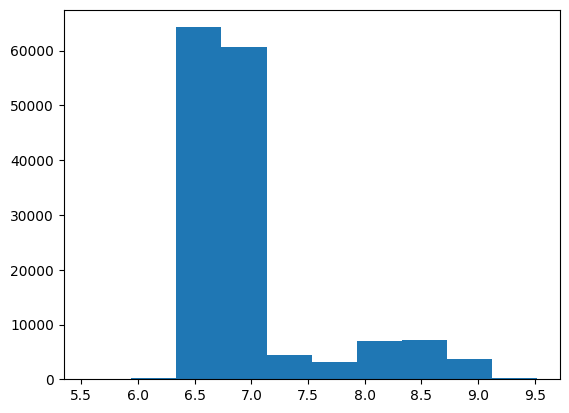

In [60]:
plt.hist(np.log10(star_mass* (1.0*u.kg).to(u.solMass).value))

In [127]:
samples = 10000
flybys = 2 # number of subhalo flybys to count, including origin subhalo
voronoi = True
dm_method = raytrace.voronoi_intersect if voronoi else raytrace.sphere_intersect
dm_name = 'dm_voronoi' if voronoi else 'dm_sphere'
data = {
    'indices': np.arange(samples, dtype=np.int64),
    'star_id': np.zeros(samples, dtype=np.int64),
    'subhalo_id': np.zeros((samples, flybys), dtype=np.int64),
    'subhalo_impact': np.zeros((samples, flybys, 3), dtype=np.float64),
    'star_mass': np.zeros(samples, dtype=np.float64),
    'star_pos': np.zeros((samples, 3), dtype=np.float64),
    'direction': np.zeros((samples, 3), dtype=np.float64),
    dm_name: np.zeros(samples, dtype=np.float64),
}
z_history = []
n_e_history = []

In [129]:
log_interval = 100
for i in data['indices']:
    star_index = rng.choice(np.arange(star_id.shape[0]))
    data['star_id'][i] = star_id[star_index]
    data['star_pos'][i] = star_pos[star_index]
    data['star_mass'][i] = star_mass[star_index]
    data['direction'][i] = raytrace.normalize(rng.normal(size=3)) # direction
    intersects, lengths = dm_method(gas_pos, 5*r.value, data['star_pos'][i], data['direction'][i], log=False)
    if len(set(gas_subhalo_id[intersects]) - { -1 }) > 1:
        print("hi")
    # data['subhalo_id'][i] = gas_subhalo_id[intersects]
    # break
    
    data[dm_name][i] = np.sum(lengths * gas_n_e[intersects])

    z_history.append(np.cumsum(lengths))
    n_e_history.append(n_e[intersects])
    
    if not i % log_interval:
        if i > 0:
            print(i, (time.time() - t)/log_interval)
        t = time.time()

100 0.17185990571975707
hi
hi
200 0.19546515464782716
hi
hi
hi
hi
300 0.16857767343521118
hi
400 0.18401797771453857
hi
hi
500 0.18244893789291383
hi
hi
hi
600 0.19829441785812377
hi
hi
700 0.18238457679748535
hi
hi
hi
hi
hi
800 0.16619741678237915
hi
hi
hi
hi
hi
hi
900 0.16362730264663697


KeyboardInterrupt: 

In [81]:
with h5py.File("outputs/dm_proto.hdf5", "a") as f:
    halo = f['halo_' + halo_id]
    if not halo['trace']:
        halo.create_group('trace')
    for k in data:
        halo['trace'][k][:] = data[k]

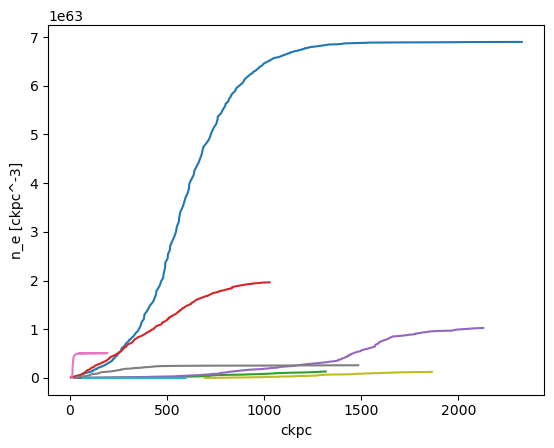

In [140]:
# plt.gca().set_yscale('log')
plt.xlabel('ckpc')
plt.ylabel('n_e [ckpc^-3]')
for i in rng.choice(range(samples), size=10):
    plt.plot(z_history[i], np.cumsum(n_e_history[i]))

In [117]:
N_convolve = 2**6
gauss = np.exp(-np.linspace(-2,2, N_convolve)**2)
conv = lambda d: np.convolve(d, gauss/np.sum(gauss), mode='valid')

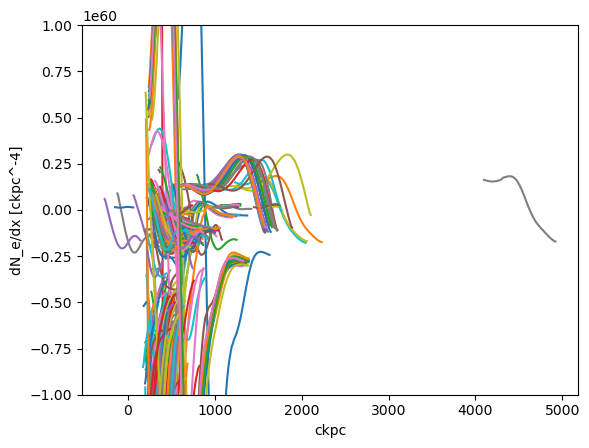

In [118]:
# plt.gca().set_yscale('log')
plt.xlabel('ckpc')
plt.ylabel('dN_e/dx [ckpc^-4]')
plt.ylim(-1e60, 1e60)
for i in range(samples):
    if len(z_history[i]) > N_convolve:
        plt.plot(conv(z_history[i]), np.gradient(conv(n_e_history[i])))

In [ ]:
dispersion_sphere = np.zeros(samples, dtype=np.float64)
for i in indices:
    t = time.time()
    b = impact[i]
    n = direction[i]
    intersects, lengths = raytrace.sphere_intersect(pos, r.value, b, n, log=False)
    dm = np.sum(lengths * n_e.value[intersects])
    dispersion_sphere[i] = dm
    times.append(time.time() - t)
print('time:',np.mean(times))

In [123]:
with h5py.File("outputs/dm_proto.hdf5", "a") as f:
    print(f.keys())
    f[group_id]["RayID"][:] = indices
    f[group_id]["Impact"][:] = impact
    f[group_id]["Direction"][:] = direction
    f[group_id]["DM"][:] = dispersion
    f[group_id]["DMSphere"][:] = dispersion_sphere

<KeysViewHDF5 ['12925051']>


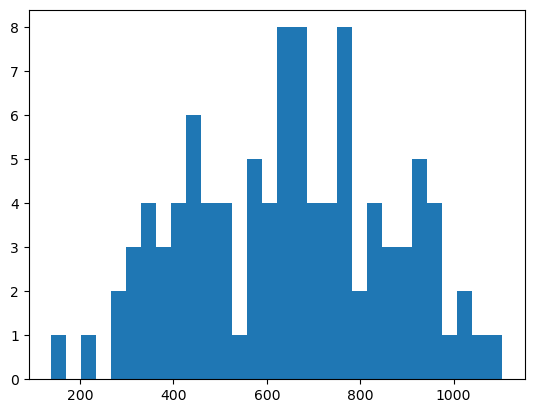

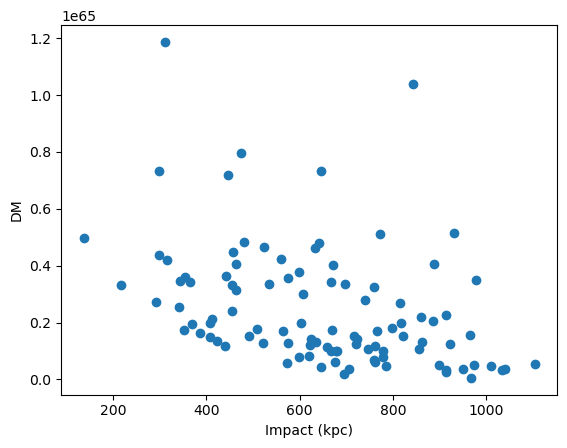

In [126]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    plt.hist(np.sqrt(raytrace.norm2(np.array(f[group_id]['Impact']))), bins=30)
    plt.show()
    plt.scatter(np.sqrt(raytrace.norm2(np.array(f[group_id]['Impact']))), np.array(f[group_id]['DMSphere']))
    plt.xlabel('Impact (kpc)')
    plt.ylabel('DM')

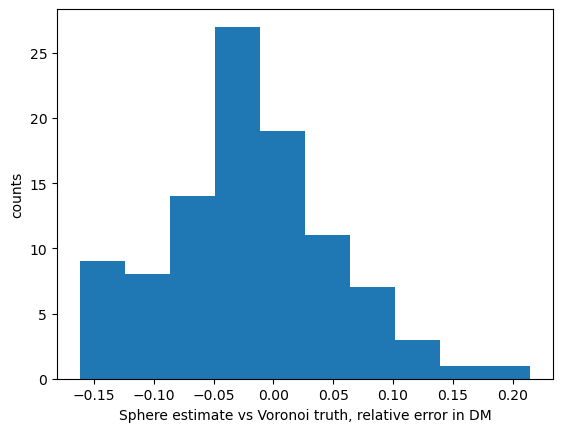

In [108]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    plt.hist(np.array(f[group_id]['DMSphere'])/np.array(f[group_id]['DM']) - 1)
    plt.xlabel('Sphere estimate vs Voronoi truth, relative error in DM')
    plt.ylabel('counts')

In [56]:
import importlib
importlib.reload(raytrace)

<module 'raytrace' from '/home/xingyzt/Documents/halo/raytrace.py'>